# Instagram Reach Analysis and Prediction

The original content from where the project is based on, you can check the full text here:

https://thecleverprogrammer.com/2022/03/22/instagram-reach-analysis-using-python/

This version is a step by step I've done to understand the original coding and ideas, since the tutorial has some outdated code and some visualizations I didn't like, I've made some changes keeping the answers but rearranging in a better view or recent code.

Also, the original code uses plotly to make some graphs, but, despite dinamical, the main goal is to show a result, not to interact with it, at least for now, so plotly will be replaced by seaborn, also due to better arranging visualizations.

Predicting the reach of a certain post is really important for marketing teams, accurate predictions based on recent trends and content help teams to figure out the best strategies to optimize ROI and the target public. The main users of this kind of tool are marketing agencies, which help them to sell ads to companies based on these values.

## Starting libraries and dataset

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import PassiveAggressiveRegressor, LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

data = pd.read_csv("https://raw.githubusercontent.com/amankharwal/Website-data/master/Instagram.csv", encoding="latin1")
data.head()

,Impressions,From Home,From Hashtags,From Explore,From Other,Saves,Comments,Shares,Likes,Profile Visits,Follows,Caption,Hashtags
0,3920.0,2586.0,1028.0,619.0,56.0,98.0,9.0,5.0,162.0,35.0,2.0,Here are some of the most important data visua...,#finance #money #business #investing #investme...
1,5394.0,2727.0,1838.0,1174.0,78.0,194.0,7.0,14.0,224.0,48.0,10.0,Here are some of the best data science project...,#healthcare #health #covid #data #datascience ...
2,4021.0,2085.0,1188.0,0.0,533.0,41.0,11.0,1.0,131.0,62.0,12.0,Learn how to train a machine learning model an...,#data #datascience #dataanalysis #dataanalytic...
3,4528.0,2700.0,621.0,932.0,73.0,172.0,10.0,7.0,213.0,23.0,8.0,Heres how you can write a Python program to d...,#python #pythonprogramming #pythonprojects #py...
4,2518.0,1704.0,255.0,279.0,37.0,96.0,5.0,4.0,123.0,8.0,0.0,Plotting annotations while visualizing your da...,#datavisualization #datascience #data #dataana...


## Making some data exploration

Let's check data consistency and then check some descriptive analytics on it. Check for null entries first.

In [2]:
data.isnull().sum()

Impressions       1
From Home         1
From Hashtags     1
From Explore      1
From Other        1
Saves             1
Comments          1
Shares            1
Likes             1
Profile Visits    1
Follows           1
Caption           1
Hashtags          1
dtype: int64

Dropping null data and then checking how much data was lost.

In [3]:
data = data.dropna()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Impressions     99 non-null     float64
 1   From Home       99 non-null     float64
 2   From Hashtags   99 non-null     float64
 3   From Explore    99 non-null     float64
 4   From Other      99 non-null     float64
 5   Saves           99 non-null     float64
 6   Comments        99 non-null     float64
 7   Shares          99 non-null     float64
 8   Likes           99 non-null     float64
 9   Profile Visits  99 non-null     float64
 10  Follows         99 non-null     float64
 11  Caption         99 non-null     object 
 12  Hashtags        99 non-null     object 
dtypes: float64(11), object(2)
memory usage: 10.8+ KB


In [5]:
data_skew = data.skew(axis=0)
data_kurt = data.kurt(axis=0)
data_median = data.median()
data.describe().T.assign(skewness = data_skew, kurtosis = data_kurt, median = data_median)

/tmp/ipykernel_4755/1437260041.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_skew = data.skew(axis=0)
/tmp/ipykernel_4755/1437260041.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_kurt = data.kurt(axis=0)
/tmp/ipykernel_4755/1437260041.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_median = data.median()


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,median
Impressions,99.0,4644.131313,2291.474570,1941.0,3225.0,3990.0,5172.5,16062.0,2.213888,6.563676,3990.0
From Home,99.0,2267.808081,567.121422,1179.0,1960.0,2195.0,2577.5,4137.0,0.799989,1.443182,2195.0
From Hashtags,99.0,1738.252525,1800.561054,116.0,655.0,1248.0,2222.0,11817.0,2.771032,10.674324,1248.0
From Explore,99.0,417.040404,511.751971,0.0,124.5,249.0,496.0,2355.0,2.595557,6.730201,249.0
From Other,99.0,137.242424,184.376118,9.0,36.0,69.0,157.5,1115.0,2.893557,9.934442,69.0
Saves,99.0,126.909091,107.821100,22.0,61.0,104.0,144.0,668.0,2.980037,11.864027,104.0
Comments,99.0,6.959596,3.610979,0.0,5.0,7.0,9.0,19.0,0.988911,1.979076,7.0
Shares,99.0,8.000000,7.398290,0.0,3.0,6.0,11.5,41.0,2.017451,6.315072,6.0
Likes,99.0,160.333333,64.883884,72.0,116.5,150.0,188.5,416.0,1.258485,1.974575,150.0
Profile Visits,99.0,38.424242,58.915555,4.0,14.0,21.0,36.5,347.0,3.992178,16.873115,21.0


## Starting the analysis

Making some visualizations on distribuitions

Text(0.5, 1.0, 'Percentage from source')

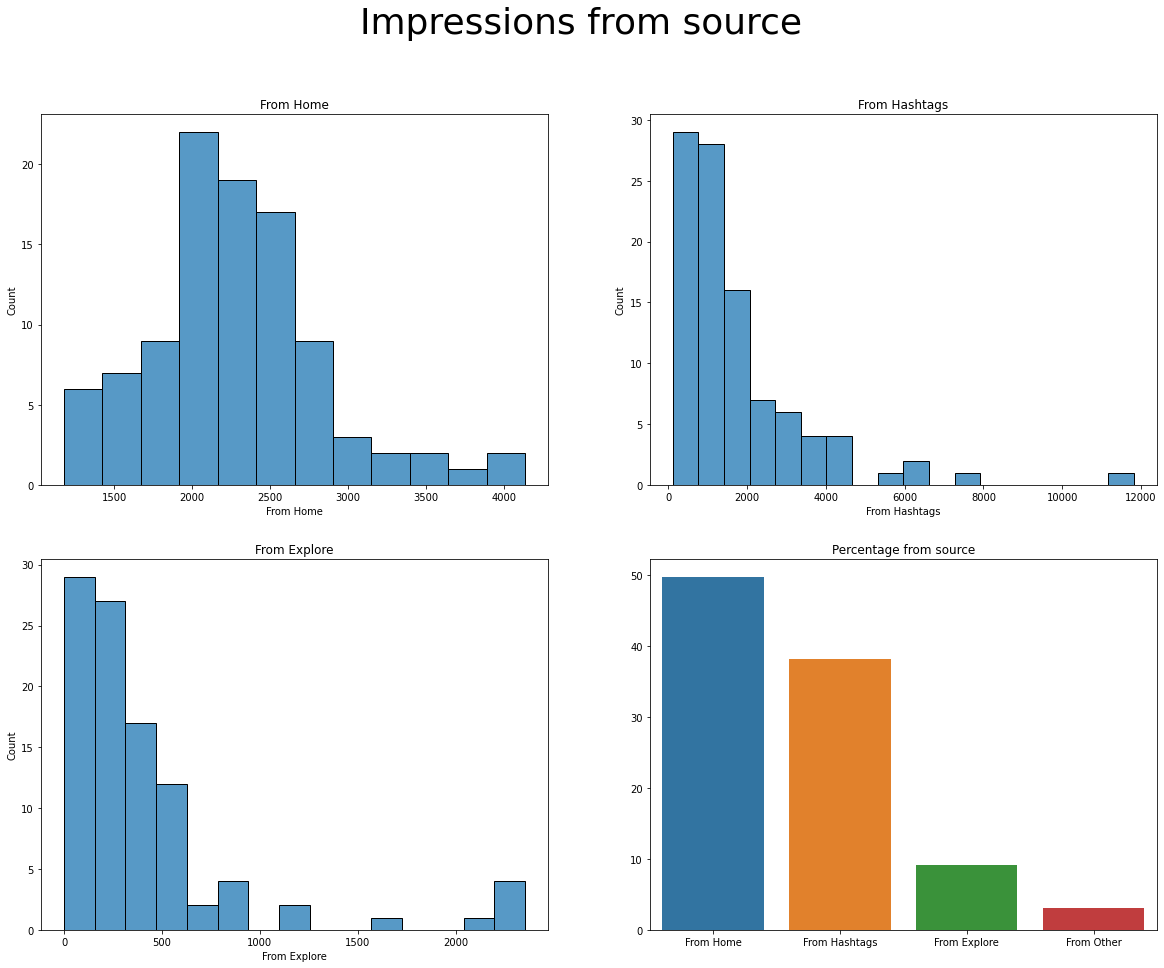

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Impressions from source", fontsize=36)

sns.histplot(data["From Home"], ax=axes[0][0])
axes[0][0].set_title("From Home")

sns.histplot(data["From Hashtags"], ax=axes[0][1])
axes[0][1].set_title("From Hashtags")

sns.histplot(data["From Explore"], ax=axes[1][0])
axes[1][0].set_title("From Explore")

total_home = data["From Home"].sum()
total_hashtags = data["From Hashtags"].sum()
total_explore = data["From Explore"].sum()
total_other = data["From Other"].sum()

total_imp = total_home + total_explore + total_hashtags + total_other

perc_home = (total_home/total_imp)*100
perc_hashtags = (total_hashtags/total_imp)*100
perc_explore = (total_explore/total_imp)*100
perc_other = (total_other/total_imp)*100

sns.barplot(y=[perc_home, perc_hashtags, perc_explore, perc_other], \
    x = ["From Home", "From Hashtags", "From Explore", "From Other"], \
    ax=axes[1][1], \
        ci=None)
axes[1][1].set_title("Percentage from source")
#axes[1][1].bar_label(axes[1][1].containers[1][1], labels=[perc_home, perc_hashtags, perc_explore, perc_other])

The content of the post can be analyzed too, checking two columns, by the frequency of the words used is possible to track the main contents by plotting a wordcloud visualization.

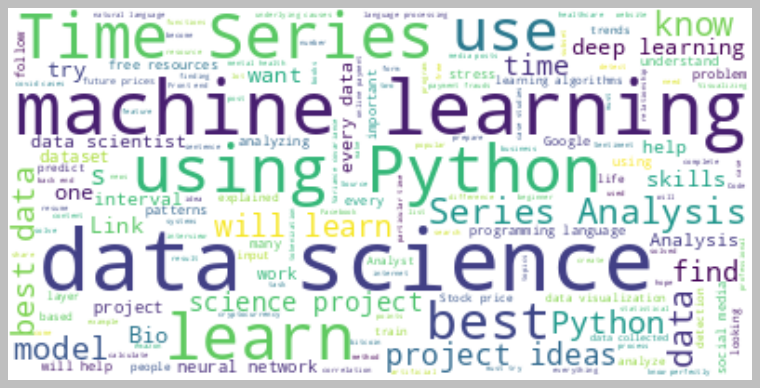

In [7]:
text = " ".join(i for i in data["Caption"])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.style.use("classic")
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The same can be done to hashtag.

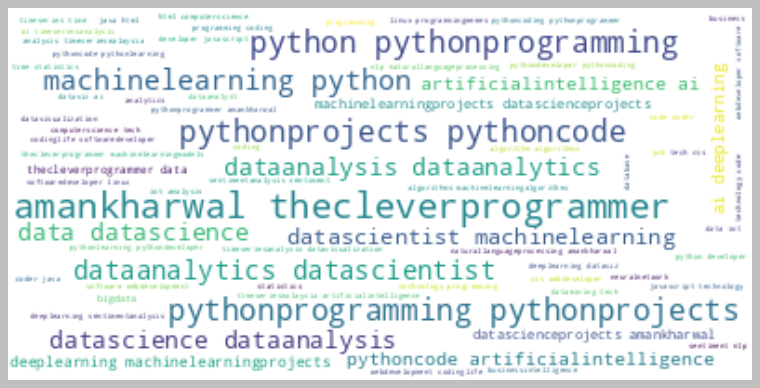

In [8]:
text = " ".join(i for i in data["Hashtags"])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.style.use("classic")
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Now is time to analyze relationsships between variables, first lets plot some correlations heatmaps.

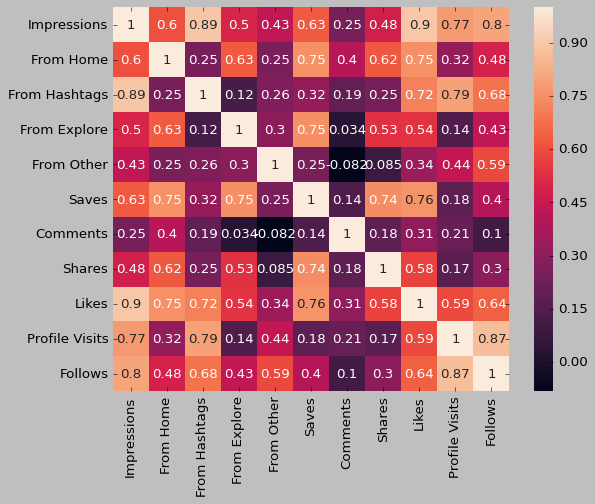

In [9]:
sns.heatmap(data.corr(), annot=True);

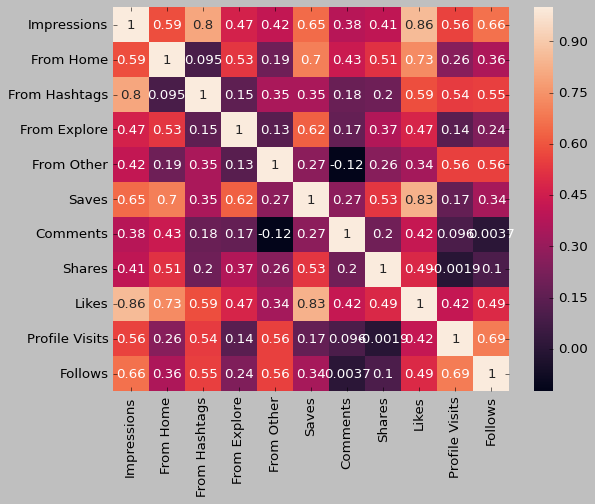

In [10]:
sns.heatmap(data.corr(method="spearman"), annot=True);

Plotting both methods of correlation is a good way to understand which variable relationship has a strongly non-linear correlation, since Spearman correlation is able to measure non-linear relations.

Now is time to see some interesting scatterplots, the plot below show how an impression is related to a given action by the user, this is possible to see how most of relationships are linear, with the point that comments are scattered, given the low correlation.

Text(0.5, 1.0, 'Impressions x Saves')

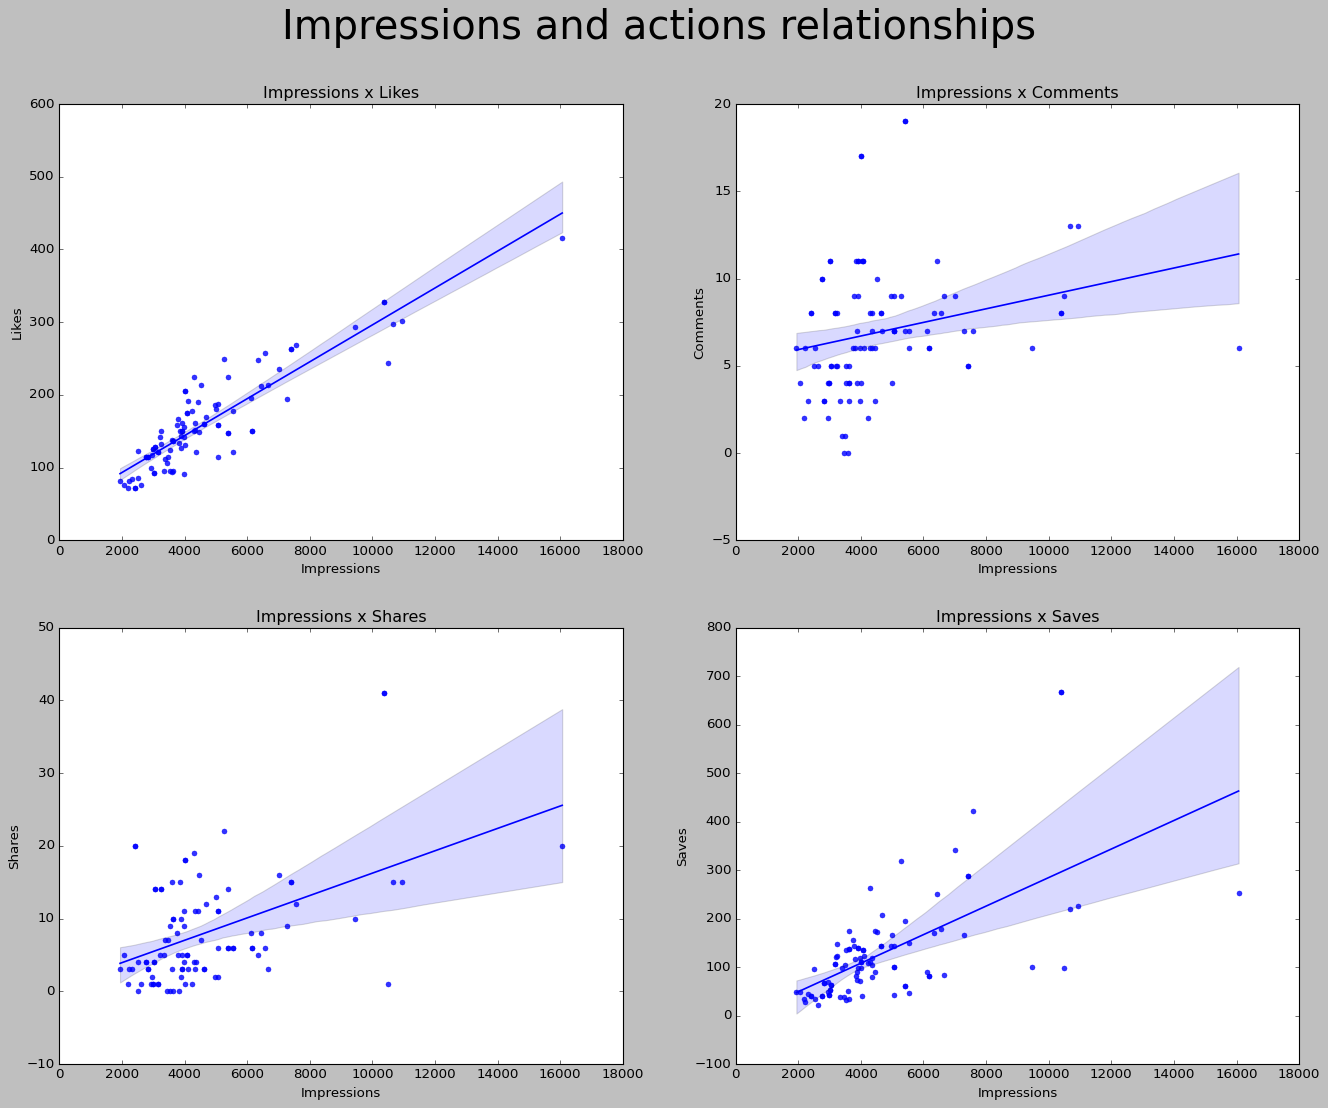

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Impressions and actions relationships", fontsize=36)

sns.regplot(data=data, x="Impressions", y="Likes", ax=axes[0][0])
axes[0][0].set_title("Impressions x Likes")

sns.regplot(data=data, x="Impressions", y="Comments", ax=axes[0][1])
axes[0][1].set_title("Impressions x Comments")

sns.regplot(data=data, x="Impressions", y="Shares", ax=axes[1][0])
axes[1][0].set_title("Impressions x Shares")

sns.regplot(data=data, x="Impressions", y="Saves", ax=axes[1][1])
axes[1][1].set_title("Impressions x Saves")

Another way to see all relationships is by using a pairplot, this is important for model training later.

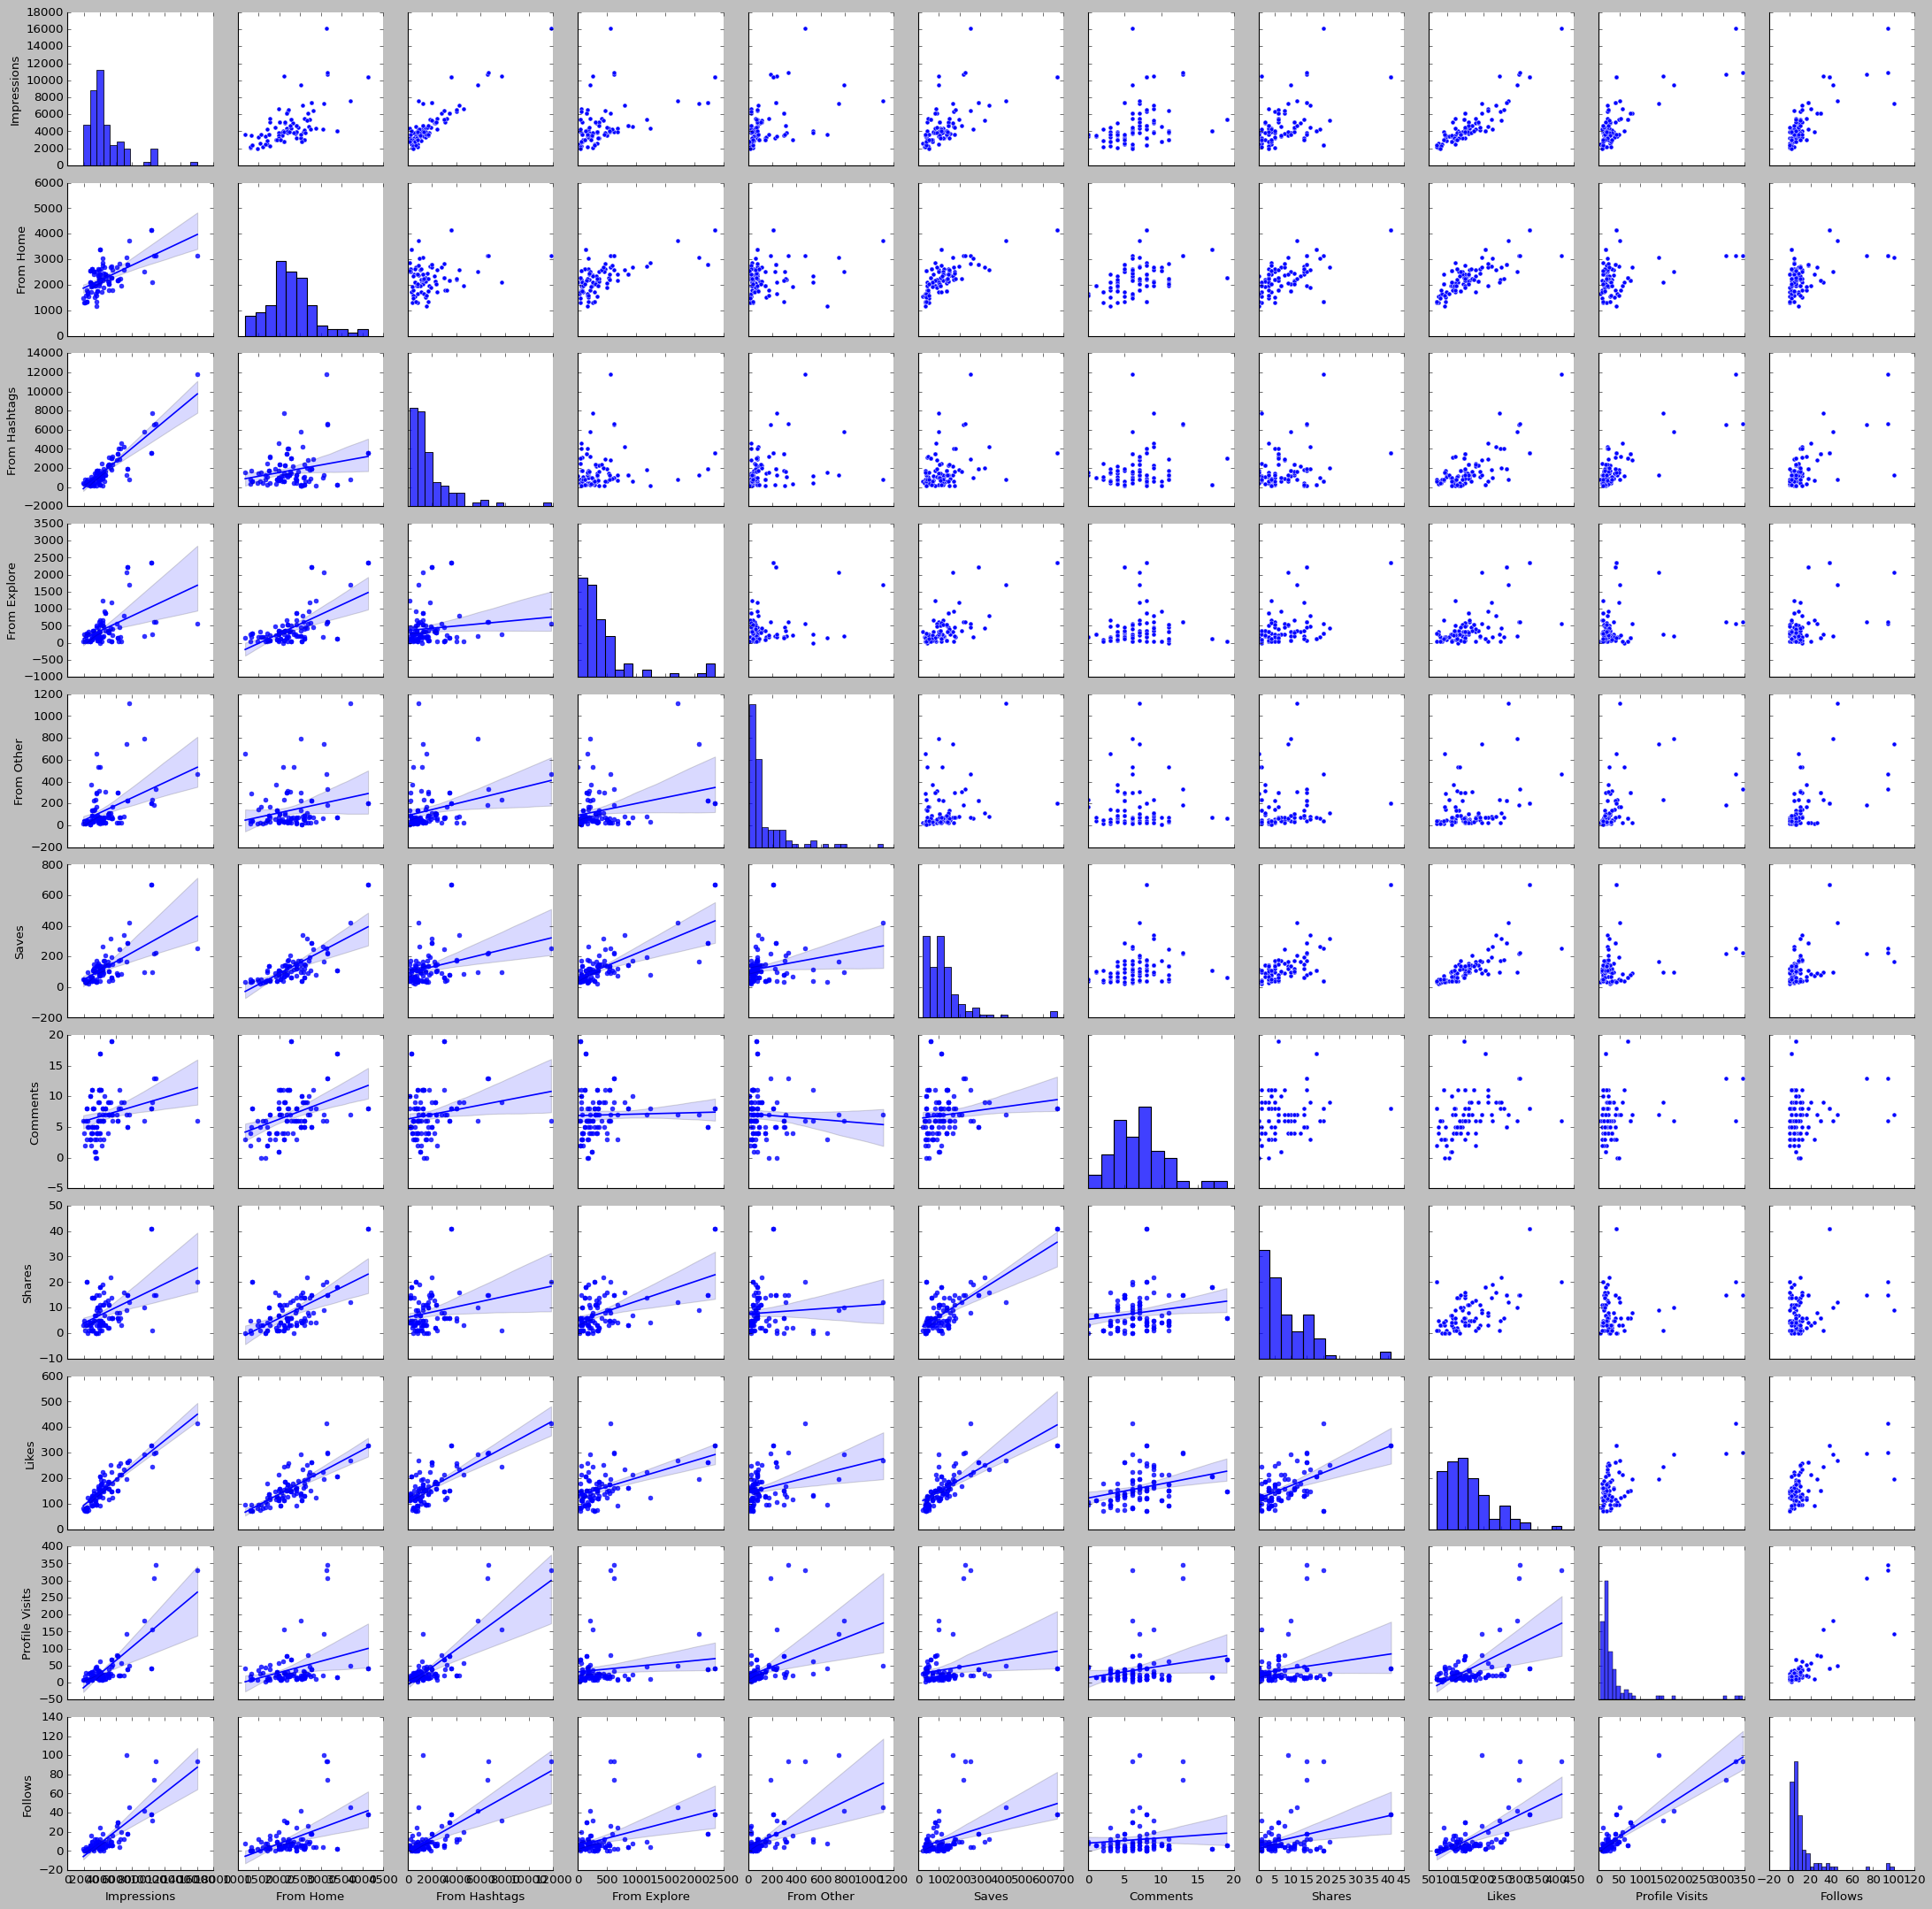

In [21]:
p = sns.PairGrid(data);
p.map_diag(sns.histplot);
p.map_upper(sns.scatterplot);
p.map_lower(sns.regplot);

# Rotating x axis bins, or changing granularity for better visualization

One more metric that is important to check is the conversion rate, which is the percentage of people that follow the profile in relation to the number of views.

By plotting both features is possible to see how they are realted, showing a linear and well correlated variables.

In [13]:
conversion_rate = (data["Follows"].sum()/data["Profile Visits"].sum())*100
conversion_rate

31.17770767613039

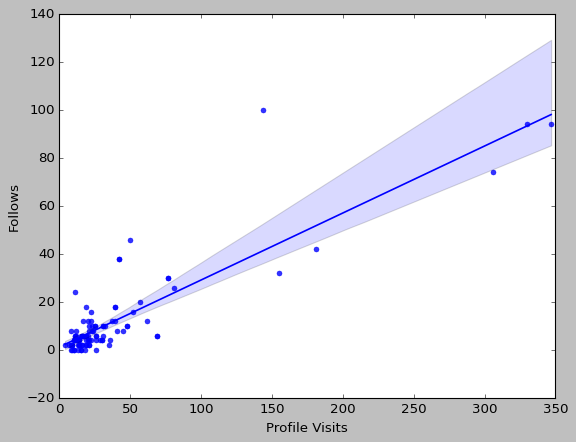

In [14]:
sns.regplot(data=data, x="Profile Visits", y="Follows");

## Building the model

Now is time to build the model to predict the reach, which is given by the number os impressions a post have.

In [15]:
x = np.array(data[['Likes', 'Saves', 'Comments', 'Shares', 
                   'Profile Visits', 'Follows']])
y = np.array(data["Impressions"])
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                test_size=0.2, 
                                                random_state=42)

The algorithm used for model building is the passive agressive regressor, due to the online learning training technique, where the algorithm learns by example not by batch of examples. This kind of algorithm is useful because the way it learns is well suited for big data applications since fast and large volume of data is generated every second.

In [36]:
model = PassiveAggressiveRegressor(early_stopping=True, random_state=42)
model.fit(xtrain, ytrain)
model.score(xtest, ytest)

0.9227729048970769

In [23]:
# Features = [['Likes','Saves', 'Comments', 'Shares', 'Profile Visits', 'Follows']]
features = np.array([[282.0, 233.0, 4.0, 9.0, 165.0, 54.0]])
model.predict(features)

array([10018.60941225])

Despite being a good choosing of a model, the original project has a lack of evaluation of the passive aggressive regressor, also, lacks the search of optimal parameters in case of deployment of such a model, so in order to find the best choice for this kind of problem, the passive aggressive regressor will be compared to a simple least squares linear regressor and a ElasticNet, in order to evaluate how Ridge, Lasso or a combination of the two regularizations can give a better score. All algorithms will be optimized in order to have the best comparison.

To have a fair comparison, the dataset will be optimized to be inputed to the least squares and elasticnet, adding another step in the pipeline, for not changing the shape of the vector space, numerical data will be standardized instead of normalized.

In [31]:
scaler = StandardScaler()
xs = scaler.fit_transform(x)
ys = scaler.fit_transform(y.reshape(-1, 1))

In [69]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.2, random_state = 42)

In [70]:
ls_model = LinearRegression()
ls_model.fit(xs_train, ys_train)
ls_model.score(xs_test, ys_test)

0.8016846856454836

In [72]:
en_model = ElasticNet(random_state=42)
en_model.fit(xs_train, ys_train)
en_model.score(xs_test, ys_test)

0.18292834901563515

In [51]:
# Time to grid search

pa_params = {"C": [t for t in np.arange(0.1, 5, 0.1)], "max_iter": [j for j in range(500, 1500, 100)], "loss": ["epsilon_insensitive", "squared_epsilon_insensitive"], 
                "epsilon": [k for k in np.arange(0.01, 0.5, 0.03)]}

pa_search = GridSearchCV(model, pa_params)

In [74]:
pa_search.fit(xtrain, ytrain)

GridSearchCV(estimator=PassiveAggressiveRegressor(early_stopping=True,
                                                  random_state=42),
             param_grid={'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                               0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                               1.2000000000000002, 1.3000000000000003,
                               1.4000000000000001, 1.5000000000000002, 1.6,
                               1.7000000000000002, 1.8000000000000003,
                               1.9000000000000001, 2.0, 2.1, 2.2,
                               2.3000000000000003, 2.4...
                               2.5000000000000004, 2.6, 2.7, 2.8000000000000003,
                               2.9000000000000004, 3.0000000000000004, ...],
                         'epsilon': [0.01, 0.04, 0.06999999999999999,
                                     0.09999999999999999, 0.13, 0.16, 0.19,
                                     0.22, 0.25, 0.28, 0.31,
                                     0.33999999999999997, 0.37, 0.4, 0.43,
                                     0.45999999999999996, 0.49],
                         'loss': ['epsilon_insensitive',
                                  'squared_epsilon_insensitive'],
                         'max_iter': [500, 600, 700, 800, 900, 1000, 1100, 1200,
                                      1300, 1400]})

In [75]:
pa_search.best_estimator_

PassiveAggressiveRegressor(C=0.1, early_stopping=True, epsilon=0.49,
                           max_iter=500, random_state=42)

In [76]:
pa_search.best_estimator_.score(xtest, ytest)

0.9232102713620266

In [78]:
en_params = {"alpha": [f for f in np.arange(0, 1, 0.1)], "l1_ratio": [l for l in np.arange(0, 1, 0.1)], 
                "max_iter": [j for j in range(500, 1500, 100)], "selection":["random", "cyclic"]}

en_search = GridSearchCV(en_model, en_params)

In [79]:
en_search.fit(xs_train, ys_train)

/home/romulo/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/romulo/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/romulo/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e+00, tolerance: 4.712e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV inst

GridSearchCV(estimator=ElasticNet(random_state=42),
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                   0.6000000000000001, 0.7000000000000001, 0.8,
                                   0.9],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                      0.5, 0.6000000000000001,
                                      0.7000000000000001, 0.8, 0.9],
                         'max_iter': [500, 600, 700, 800, 900, 1000, 1100, 1200,
                                      1300, 1400],
                         'selection': ['random', 'cyclic']})

In [80]:
en_search.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.30000000000000004, max_iter=500,
           random_state=42, selection='random')

In [81]:
en_search.best_estimator_.score(xs_test, ys_test)

0.8280122197150533

After finding the best combination of parameters for ElasticNet and the Passive Aggressive Regressor, it's time to evaluate other measures of performance in order to understand which model is worth using in a production test. In order to evaluate the error Root Mean Squarred Error will be used to evaluate the consistency of the data, and r² will be used to determine how well the model is determining results and last the coefficients to understand which feature has the greatest influence in the results.

In [85]:
ypred = pa_search.best_estimator_.predict(xtest)

In [88]:
r2_score(ytest, ypred)

0.9232102713620266

In [89]:
mean_squared_error(ytest, ypred)

760069.0565524861

In [90]:
# Features = [['Likes','Saves', 'Comments', 'Shares', 'Profile Visits', 'Follows']]
pa_search.best_estimator_.coef_

array([28.04253855, -0.27305005,  6.19832698,  8.41545626,  9.52629785,
       15.15274045])

In [93]:
ls_y_pred = ls_model.predict(xs_test)

In [94]:
r2_score(ys_test, ls_y_pred)

0.8016846856454836

In [100]:
scaler.inverse_transform(np.array([mean_squared_error(ys_test, ls_y_pred)]).reshape(-1, 1))

array([[5505.11651956]])

In [96]:
# Features = [['Likes','Saves', 'Comments', 'Shares', 'Profile Visits', 'Follows']]
ls_model.coef_

array([[ 0.51812584,  0.10240036, -0.03401056, -0.03460786, -0.02370852,
         0.4871887 ]])

In [101]:
en_y_pred = en_search.best_estimator_.predict(xs_test)

In [102]:
r2_score(ys_test, en_y_pred)

0.8280122197150533

In [103]:
scaler.inverse_transform(np.array([mean_squared_error(ys_test, en_y_pred)]).reshape(-1, 1))

array([[5390.81562742]])

In [104]:
# Features = [['Likes','Saves', 'Comments', 'Shares', 'Profile Visits', 'Follows']]
en_search.best_estimator_.coef_

array([ 0.41127059,  0.15374373, -0.        ,  0.        ,  0.13011672,
        0.2754269 ])

After analysing results is clear that even though the Passive Aggressive Regressor gives a much better R² result, it still has a high RMSE, which means that the model can either over predict or under predict by that value, when in fact the other two models are much more consistent to the true results, even though the simplicity they have.

Another conclusion is that "Likes" and "Follows" are very decisive features to predict whether your post is going to have a bigger reach than the previous one, that is a trend across all models.

Lastly, is import to point out that the PA Regressor performs better with large amounts of data, that can be one of the reasons the model is not being consistent in its predictions. That is why more data on the matter is necessary and constant follow up, yet, in the actual state of affairs ElasticNet model provided the best results and should be used for testing for now. In case of large streams of data new tests should be realized to check if the model is still performing well.